In [2]:
#Imports, set cuda device, configure tensor board

import torch
from datasets import DepthDataset
from torchvision.transforms import v2, InterpolationMode
from modules.depth_estimation_model import DepthEstimiationModel
from modules.ego_motion_filter import GeometryFilter
from modules.identity import Identity
from torch import nn
import trainer
import util

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from torch.utils.tensorboard import SummaryWriter
import os
import shutil


TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "vanilla_dae")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

ModuleNotFoundError: No module named 'depth_decoder'

In [ ]:
root_dir = "/home/nfs/inf6/data/datasets/Carla_Moritz/SyncAngel3/"

transforms = v2.Compose([
    v2.Resize((256, 512), InterpolationMode.BILINEAR, antialias=False),
    v2.ToDtype(torch.float, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = DepthDataset(root_dir, transform=transforms, split='train')
#test_dataset = CarlaDataset(root_dir, transform=transforms, split='test')
valid_dataset = DepthDataset(root_dir, transform=transforms, split='validation')


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=8)


geometry_filter = GeometryFilter()
filter = Identity()
model = DepthEstimiationModel(filter=filter, freeze_backbone=False)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.to(device)
model.eval()


DepthEstimiationModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [7]:
image, target = next(iter(train_loader))
image = image.to(device)
#del image

In [1]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)

NameError: name 'nn' is not defined

In [5]:
trainer.train_model(model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion, 
                    train_loader=train_loader, valid_loader=valid_loader, num_epochs=2, writer=writer, device=device, save_frequency=1)

  0%|          | 0/44985 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 10.75 GiB of which 768.56 MiB is free. Including non-PyTorch memory, this process has 7.64 GiB memory in use. Process 711298 has 216.00 MiB memory in use. Process 711474 has 216.00 MiB memory in use. Process 711525 has 216.00 MiB memory in use. Process 711555 has 216.00 MiB memory in use. Process 711778 has 216.00 MiB memory in use. Process 711805 has 216.00 MiB memory in use. Process 711877 has 216.00 MiB memory in use. Process 712001 has 216.00 MiB memory in use. Process 712052 has 216.00 MiB memory in use. Process 712140 has 216.00 MiB memory in use. Process 712330 has 216.00 MiB memory in use. Of the allocated memory 7.37 GiB is allocated by PyTorch, and 78.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
savepath = 'models/checkpoint_epoch_10.pth'
model, optimizer, epoch, stats = util.load_model(model, optimizer, savepath)

In [ ]:
image, target = next(iter(train_loader))
image = image.to(device)
out = model.backbone(image)["out"].shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacty of 23.69 GiB of which 711.88 MiB is free. Process 3256202 has 19.54 GiB memory in use. Including non-PyTorch memory, this process has 3.38 GiB memory in use. Of the allocated memory 2.97 GiB is allocated by PyTorch, and 110.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

torch.Size([16, 22, 256, 512])


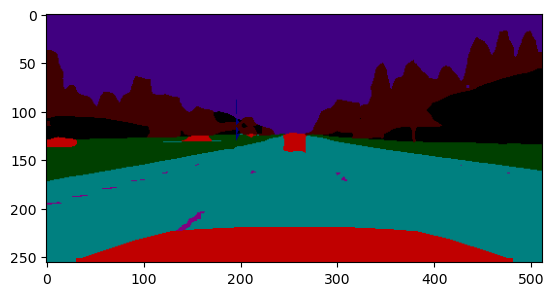

In [ ]:
import segmentation_utils
import matplotlib.pyplot as plt

image, target = next(iter(train_loader))
result = model(image.to(device))["out"]
prediction = result.softmax(dim=1)
print(prediction.shape)  
segmentation_map = segmentation_utils.draw_segmentation_map(prediction[0])
plt.imshow(segmentation_map)


In [ ]:
result[0]

NameError: name 'result' is not defined

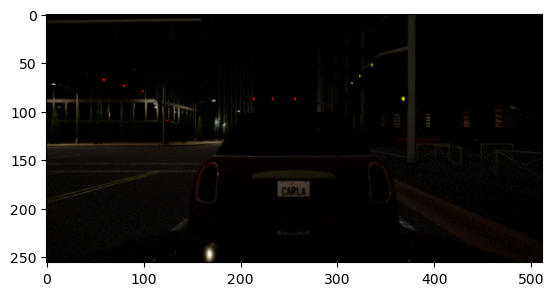

In [ ]:
plt.imshow(image[0].permute(1,2,0))

In [ ]:
numbers = [1, 2, 3, 4, 5]
[sum(numbers[:i]) for i in range(len(numbers))]

[0, 1, 3, 6, 10]

In [ ]:
[sum(numbers[:j]) for j in [len(train_dataset.excluded_sequences[i]) * 20 for i in train_dataset.towns[:3]]]

[0, 20, 0]

In [ ]:
a = [30000 - len(train_dataset.excluded_sequences[i]) * 20 for i in train_dataset.towns]
print(a)
b = [sum(a[:i+1]) for i in range(len(a))]
c = [i > idx for i in b].index(True)
print(b)
idx = 30000
c
[b[i-1] if i>0 else 0 for i in range(len(b))]

[30000, 29980, 30000, 30000, 30000, 30000]
[30000, 59980, 89980, 119980, 149980, 179980]


[0, 30000, 59980, 89980, 119980, 149980]

In [ ]:
[i > idx for i in b]

[False, True, True]

In [ ]:
a[:9]

[30000, 29980, 30000, 30000, 30000, 30000]

In [ ]:
def get_entry(x, excluded_values):
    """
    Get the xth entry from a list of numbers with certain excluded values.

    Parameters:
        x (int): The index of the entry to retrieve.
        excluded_values (list): List of values to be excluded from the list.

    Returns:
        int: The xth entry from the list.
    """
    # Adjust the index based on the number of excluded values that come before it
    adjusted_index = x + len([val for val in excluded_values if val <= x])


    return adjusted_index

# Example usage:

x = 6  # Index of the entry to retrieve
result = get_entry(x, excluded_values)
print(f"The {x}th entry is: {result}")

The 6th entry is: 7


In [ ]:
y = 5
excluded_values = [4, 1]  # Define excluded values
[x for x in range(y + len(excluded_values) + 1) if x not in excluded_values][y]

7

In [ ]:
train_dataset[59919]

/home/nfs/inf6/data/datasets/Carla_Moritz/SyncAngel3/Town03/seq_1496/img_019.png


(tensor([[[0.2196, 0.0941, 0.0000,  ..., 0.0275, 0.0157, 0.0510],
          [0.2196, 0.0902, 0.0000,  ..., 0.0275, 0.0157, 0.0392],
          [0.2353, 0.0941, 0.0000,  ..., 0.0510, 0.0392, 0.0157],
          ...,
          [0.0941, 0.0863, 0.0863,  ..., 0.2118, 0.2196, 0.2157],
          [0.0863, 0.0863, 0.1059,  ..., 0.2118, 0.2118, 0.2196],
          [0.0941, 0.0941, 0.1059,  ..., 0.2078, 0.2039, 0.2039]],
 
         [[0.1882, 0.0824, 0.0000,  ..., 0.0000, 0.0000, 0.0157],
          [0.1843, 0.0706, 0.0000,  ..., 0.0000, 0.0157, 0.0000],
          [0.1961, 0.0549, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0627, 0.0784, 0.0627,  ..., 0.1765, 0.1804, 0.1843],
          [0.0784, 0.0784, 0.0784,  ..., 0.1765, 0.1725, 0.1843],
          [0.0784, 0.0784, 0.0784,  ..., 0.1725, 0.1725, 0.1686]],
 
         [[0.1059, 0.0275, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1059, 0.0392, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1176, 0.0353, 0.0000,  ...,

In [ ]:
train_dataset.cum_images

[30000, 59980, 89980, 119980, 149980, 179980]

In [ ]:
idx = 0
town_index = [i > idx for i in train_dataset.cum_images].index(True)
town = train_dataset.towns[town_index]
excluded = train_dataset.excluded_sequences[town]
start_indices = [train_dataset.cum_images[i-1] if i>0 else 0 for i in range(len(train_dataset.cum_images))]
image_num_in_town = idx - start_indices[town_index]
sequence = (image_num_in_town) // 20

In [ ]:
sequence

0

In [ ]:
import numpy as np

np.load("/home/nfs/inf6/data/datasets/Carla_Moritz/SyncAngel3/Town01/seq_0001/optical_flow_000.npy").shape

(512, 1024, 2)

In [ ]:
import pickle

with open('/home/nfs/inf6/data/datasets/Carla_Moritz/SyncAngel3/Town01/seq_0001/meta.pkl', 'rb') as f:
    data = pickle.load(f)


[[[-0.0024863688740879297,
   -0.9999969005584717,
   -0.00022413748956751078,
   392.2984619140625],
  [0.9999886155128479,
   -0.0024854373186826706,
   -0.004065237939357758,
   106.20295715332031],
  [0.004064667969942093,
   -0.0002342426305403933,
   0.9999917149543762,
   1.3939177989959717],
  [0.0, 0.0, 0.0, 1.0]],
 [[-0.0017084021819755435,
   -0.9999985098838806,
   -0.00032532549812458456,
   392.2980041503906],
  [0.9999815821647644,
   -0.001706478069536388,
   -0.0058255731128156185,
   107.02346801757812],
  [0.005825009196996689,
   -0.0003352718777023256,
   0.9999829530715942,
   1.3952901363372803],
  [0.0, 0.0, 0.0, 1.0]],
 [[-0.0010659906547516584,
   -0.9999993443489075,
   -0.0002934445219580084,
   392.29779052734375],
  [0.9999784827232361,
   -0.0010640696855261922,
   -0.006470235530287027,
   107.88467407226562],
  [0.006469919346272945,
   -0.00030033543589524925,
   0.9999790191650391,
   1.3957878351211548],
  [0.0, 0.0, 0.0, 1.0]],
 [[-0.000697289186064

In [ ]:
len(data['extrinsics'])

20